In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
bigp = ['AL', 'BNP', 'Jamaat', 'JaPa']
mainp = ['AL', 'BNP']
years = [1991, 1996, 2001, 2008]

In [3]:
dfc = pd.read_csv('data/candidate_result.csv')
dfc.head()

,seat,year,party,name,votes,votes_pc,winner
0,Dhaka-3,2008,BNP,Gayeshwar Chandra Roy,70680.0,36.71,no
1,Dhaka-6,1991,Independent,Sayed Sharafat Hossain,8.0,0.01,no
2,Dhaka-6,1991,Jatiya Janata Party (Asad),Md. Afzalul Huq Afzal,9.0,0.01,no
3,Comilla-3,2001,Independent,Md. Ainul Haque,12.0,0.01,no
4,Dhaka-5,1991,Jatiyatabadi Gonotantrik Chashi Dal,Afzaluddin Chowdhury,14.0,0.01,no


In [4]:
dfc.shape

(8747, 7)

In [5]:
# only take 1991-2008 election data
dfc = dfc[dfc.year.isin(years)]
dfc.shape

(8183, 7)

In [6]:
# only take winners data
dfcwin = dfc[dfc.winner == 'yes']
dfcwin.head()

,seat,year,party,name,votes,votes_pc,winner
5411,Noakhali-3,1991,BNP,Salah Uddin Kamran,11378.0,22.23,yes
5749,Mymensingh-8,1991,JaPa,Khurram Khan Chowdhury,18209.0,24.68,yes
5805,Barguna-2,1991,Independent,Nurul Islam Moni,19616.0,28.41,yes
5860,Kurigram-3,1991,AL,Md. Amjad Hossain Talukdar,20547.0,23.74,yes
5896,Noakhali-1,1991,BNP,Zainul Abdin Farroque,21418.0,31.97,yes


In [7]:
dfcwin.shape

(1150, 7)

In [8]:
bdmap = gpd.read_file('map/seats.shp')
bdmap.head()

,seat_no,seat,district,division,region,shape_len,shape_area,geometry
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."
2,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788..."
3,4,Thakurgaon-2,Thakurgaon,Rangpur,Rural,1.858839,0.045806,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,..."
4,5,Thakurgaon-3,Thakurgaon,Rangpur,Rural,1.810654,0.059069,"POLYGON ((88.25475 26.03583, 88.25828 26.03391..."


In [9]:
dfs = pd.read_csv('data/seat_summary.csv')
dfs.head()

,seat,year,turnout,turnout_pc,voters
0,Panchagarh-1,2024,192579.0,44.08,436923.0
1,Panchagarh-1,2018,320597.0,84.54,379207.0
2,Panchagarh-1,2014,86046.0,26.16,328959.0
3,Panchagarh-1,2008,266812.0,91.70,291095.0
4,Panchagarh-1,2001,206827.0,86.15,240073.0


In [10]:
dfg_seat_year = dfc.groupby(['seat', 'year'])

vdiffpc_data = []

# find vote difference in % between top 2 candidates of each seat each year
for gcols, dfg in dfg_seat_year:
    # for a given seat and year, get vote counts of top 2 candidates 
    votes = dfg.sort_values(by=['votes'], ascending=False).head(2)['votes'].to_list()
    if len(votes) < 2:
        continue
    # find vote difference
    vdiff = abs(votes[0] - votes[1])
    seat, year = gcols
    # get turnout number for a given seat and year
    turnout = dfs[(dfs.seat == seat) & (dfs.year == year)].head(1)['turnout'].to_list()
    if len(turnout) < 1 or np.isnan(turnout[0]):
        continue
    # find vote difference in % with respect to turnout
    vdiffpc = round(vdiff / int(turnout[0]) * 100, 2)
    vdiffpc_data.append((seat, year, vdiffpc))
    
dfvdpc = pd.DataFrame(vdiffpc_data, columns=['seat', 'year', 'vdiff_pc'])
dfvdpc.head()

,seat,year,vdiff_pc
0,Bagerhat-1,1991,17.01
1,Bagerhat-1,1996,19.95
2,Bagerhat-1,2001,12.32
3,Bagerhat-1,2008,40.34
4,Bagerhat-2,1991,1.12


In [11]:
# find median vote difference % of each seat
vdpc_med = dfvdpc.groupby('seat').median()['vdiff_pc']

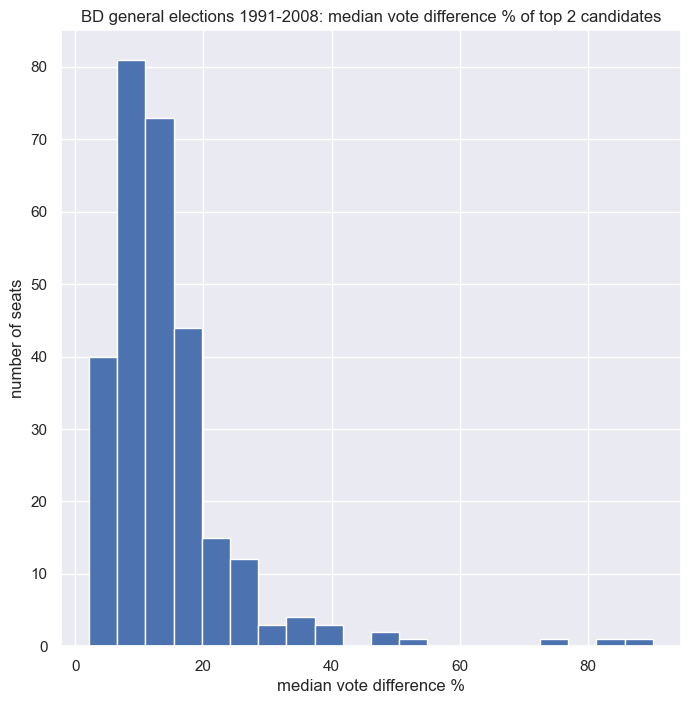

In [12]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 8))
vdpc_med.hist(bins=20, ax=ax)
ax.set_title('BD general elections 1991-2008: median vote difference % of top 2 candidates')
ax.set_xlabel('median vote difference %')
ax.set_ylabel('number of seats')
fig.savefig('fig/vote_diff_med_distn',bbox_inches='tight')

In [13]:
# find close contest seats (median vote difference % < 20)
cc = vdpc_med[vdpc_med <= 20].round(decimals=2)
cc.shape

(240,)

In [14]:
# join data with map data
map_cc = pd.merge(bdmap, cc, how='left', left_on='seat', right_index=True)[['seat', 'geometry', 'vdiff_pc']]
map_cc.head()

,seat,geometry,vdiff_pc
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",6.94
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",8.82
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",16.36
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",10.20
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",7.85


In [15]:
map_cc[['seat', 'vdiff_pc']].rename(columns={'vdiff_pc': 'vote_diff_pc'}).to_csv('dataout/allp_close_contest.csv', index=False)

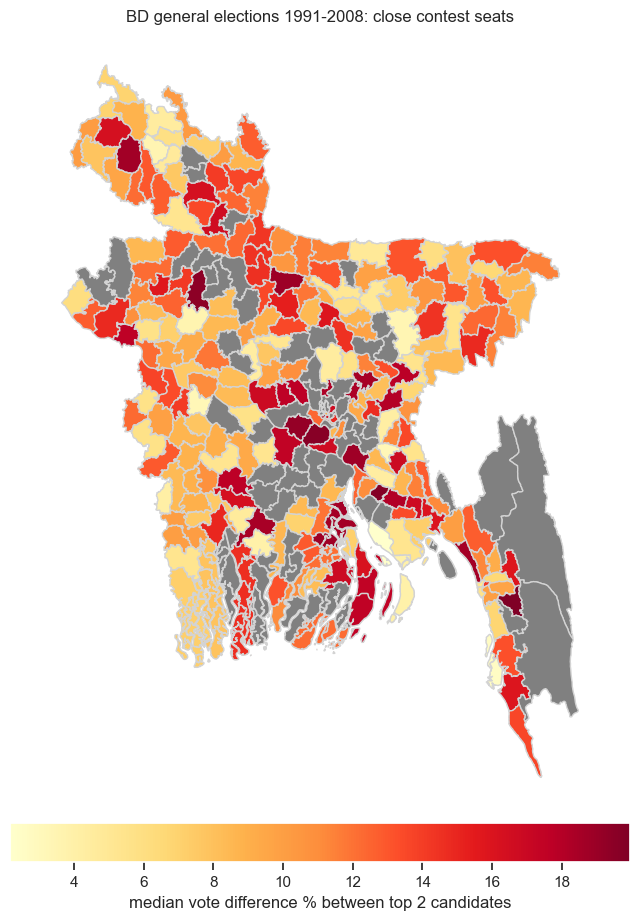

In [16]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_cc.plot(
    column='vdiff_pc', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "not close contest",
    }, 
    legend_kwds={
    'label': 'median vote difference % between top 2 candidates',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: close contest seats")
fig.savefig('fig/allp_close_contest',bbox_inches='tight')

In [17]:
# find landslide victory seats (median vote difference % > 40)
ls = vdpc_med[vdpc_med >= 40].round(decimals=2)
ls.shape

(8,)

In [18]:
# join data with map data
map_ls = pd.merge(bdmap, ls, how='left', left_on='seat', right_index=True)[['seat', 'geometry', 'vdiff_pc']]
map_ls.head()

,seat,geometry,vdiff_pc
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",NaN
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",NaN
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",NaN
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",NaN
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",NaN


In [19]:
map_ls[['seat', 'vdiff_pc']].rename(columns={
    'vdiff_pc': 'vote_diff_pc'
}).to_csv('dataout/allp_landslide_victory.csv', index=False)

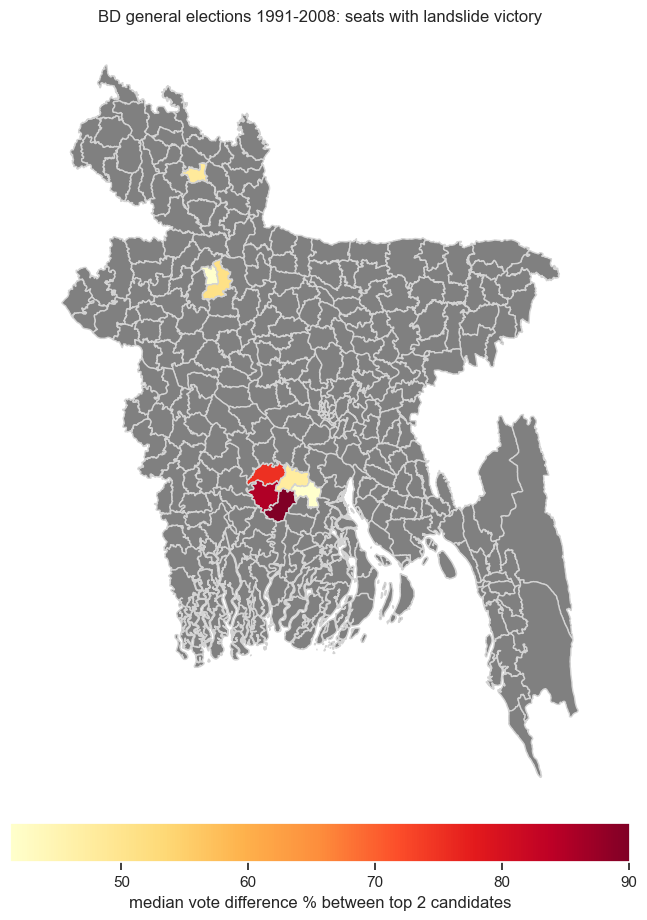

In [20]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_ls.plot(
    column='vdiff_pc', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "not landslide victory",
    }, 
    legend_kwds={
    'label': 'median vote difference % between top 2 candidates',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: seats with landslide victory")
fig.savefig('fig/allp_landslide_victory',bbox_inches='tight')